In [4]:
import ee
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

import geemap
from geeml.utils import eeprint
import matplotlib.pyplot as plt
import numpy as np

In [5]:
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/aliens_sep2018')
eeprint(pts.limit(5))

In [4]:
def createComposite(imageCollection: str, point: ee.Geometry, year: int, period:str):
    """Creates a composite image of a point over a given year (uses 1 month period for 2018 and 2 months for 2023).
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
        period (str): Either values of first (Sept-09), second(oct-Nov) or both. 
    
    Returns:
        ee.Image: The composite image.
    """

    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    if period == 'first':
        startDate = f'{year}-09-01'
        endDate = f'{year}-10-01'
    elif period == 'second':
        startDate = f'{year}-10-01'
        endDate = f'{year}-12-01'
    # elif period == 'both':
        

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65
    
    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(point).linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()
    
    return medianImage.divide(10000)

def getSpectralSignature(image: ee.Image, point: ee.Geometry, scale: int = 10):
    """Plots the spectral signature of a point on an image.
    
    Args:
        image (ee.Image): The image to plot the spectral signature on.
        point (ee.Geometry): The point to plot the spectral signature for.
        includeMap (bool, optional): Whether to include a map of the image. Defaults to True.
        scale (int, optional): The scale to plot the spectral signature at. Defaults to None.
    """

    # Get the spectral signature of the point
    spectralSignature = image.select('B.*').reduceRegion(reducer = ee.Reducer.first()
                                                        , geometry = point
                                                        , scale = scale)

    # Convert to geodataframe
    pts_gdf = ee.data.computeFeatures({
        'expression': spectralSignature,
        'fileFormat': 'PANDAS_DATAFRAME'
    })
    
    return pts_gdf

def plot_spectral_and_map(ds, crs_from='EPSG:32610', crs_to='EPSG:4326'):
    """
    Plot both spectral signature and location map for a random point, including a bounding box.
    
    Parameters:
    ds: xarray Dataset containing spectral data
    crs_from: The CRS of your input coordinates (default UTM Zone 10N)
    crs_to: The target CRS (default WGS84)
    """
    

In [8]:
point = pts.first().geometry()

composite2018 = createComposite("COPERNICUS/S2_HARMONIZED", point, 2018)
eeprint(composite2018)

Map = geemap.Map()
Map.addLayer(composite2018, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, '2018 composite')
Map.addLayer(point, {'color': 'red'}, 'random point')
Map

TypeError: createComposite() missing 1 required positional argument: 'period'

In [9]:
# Function to plot spectral signatures and display the map
def plot_spectral_signatures_and_map(point, composite2018, composite2023):
    # Get the spectral signature of the point for 2018 and 2023
    refl2018 = composite2018.select('B.*').reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=10
    ).getInfo()

    refl2023 = composite2023.select('B.*').reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=10
    ).getInfo()

    # Central wavelengths for Sentinel-2 bands (in micrometers)
    wl = {
        "B1": 0.443,  # Coastal aerosol
        "B2": 0.490,  # Blue
        "B3": 0.560,  # Green
        "B4": 0.665,  # Red
        "B5": 0.705,  # Vegetation red edge
        "B6": 0.740,  # Vegetation red edge
        "B7": 0.783,  # Vegetation red edge
        "B8": 0.842,  # NIR
        "B8A": 0.865, # Narrow NIR
        "B9": 0.945,  # Water vapor
        "B10": 1.375, # SWIR - Cirrus
        "B11": 1.610, # SWIR
        "B12": 2.190  # SWIR
    }

    # Extract reflectance values for each band and sort by wavelength
    def get_sorted_data(refl):
        reflectance = {band: refl[band] for band in wl.keys()}
        sorted_data = sorted(zip(wl.values(), reflectance.values(), wl.keys()), key=lambda x: x[0])
        wavelengths, reflectance_values, bands = zip(*sorted_data)
        return wavelengths, reflectance_values, bands

    wavelengths2018, reflectance2018, bands2018 = get_sorted_data(refl2018)
    wavelengths2023, reflectance2023, bands2023 = get_sorted_data(refl2023)

    # Create the spectral plot
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths2018, reflectance2018, marker='o', linestyle='-', color='b', label='2018 Spectral Reflectance')
    plt.plot(wavelengths2023, reflectance2023, marker='o', linestyle='-', color='r', label='2023 Spectral Reflectance')

    # Add labels and title
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Reflectance')
    plt.title('Spectral Reflectance of Sentinel-2 Bands (2018 vs 2023)')
    plt.grid(True)

    # Annotate the bands
    for band, x, y in zip(bands2018, wavelengths2018, reflectance2018):
        plt.text(x, y, band, fontsize=9, ha='right')

    # Show the plot
    plt.legend()
    plt.show()

    # Display the map with the composite and the point
    Map = geemap.Map()
    Map.addLayer(composite2018, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, '2018 composite')
    Map.addLayer(composite2023, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, '2023 composite')
    Map.addLayer(point, {'color': 'red'}, 'random point')
    Map.centerObject(point, zoom=12)
    Map

# Example usage
point = pts.first().geometry()  # Replace `pts` with your feature collection
composite2018 = createComposite("COPERNICUS/S2_HARMONIZED", point, 2018)
composite2023 = createComposite("COPERNICUS/S2_HARMONIZED", point, 2023)

# Plot spectral signatures and display the map
plot_spectral_signatures_and_map(point, composite2018, composite2023)

TypeError: createComposite() missing 1 required positional argument: 'period'

In [7]:
def createComposite(imageCollection: str, point: ee.Geometry, year: int, period: str):
    """Creates a composite image of a point over a given year and period.
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
        period (str): Either 'first' (Sept), 'second' (Oct-Nov), or 'both'.
    
    Returns:
        ee.Image: The composite image.
    """
    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    # Set date ranges based on period
    if period == 'first':
        startDate = f'{year}-09-01'
        endDate = f'{year}-10-01'
    elif period == 'second':
        startDate = f'{year}-10-01'
        endDate = f'{year}-12-01'
    elif period == 'both':
        startDate = f'{year}-09-01'
        endDate = f'{year}-12-01'
    else:
        raise ValueError("Period must be 'first', 'second', or 'both'")

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65
    
    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(point)\
    .linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()
    
    return medianImage.divide(10000)

# Function to plot spectral signatures across multiple years and periods
def plot_spectral_signatures_and_map(point, start_year, end_year, periods=None):
    """
    Plot spectral signatures across multiple years and time periods.
    
    Args:
        point (ee.Geometry): The point to analyze
        start_year (int): The starting year
        end_year (int): The ending year
        periods (list): List of periods to include ('first', 'second', 'both'). 
                        If None, defaults to ['both']
    
    Returns:
        geemap.Map: A map with all composites and the point
    """
    if periods is None:
        periods = ['both']
    
    # Create composites for each year and period in the range
    composites = {}
    for year in range(start_year, end_year + 1):
        for period in periods:
            key = f"{year}_{period}"
            composites[key] = createComposite("COPERNICUS/S2_HARMONIZED", point, year, period)
    
    # Central wavelengths for Sentinel-2 bands (in micrometers)
    wl = {
        "B1": 0.443,  # Coastal aerosol
        "B2": 0.490,  # Blue
        "B3": 0.560,  # Green
        "B4": 0.665,  # Red
        "B5": 0.705,  # Vegetation red edge
        "B6": 0.740,  # Vegetation red edge
        "B7": 0.783,  # Vegetation red edge
        "B8": 0.842,  # NIR
        "B8A": 0.865, # Narrow NIR
        "B9": 0.945,  # Water vapor
        "B11": 1.610, # SWIR
        "B12": 2.190  # SWIR
    }
    
    # Create the spectral plot
    plt.figure(figsize=(15, 8))
    
    # Color map for the years and periods
    num_items = len(composites)
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, num_items))
    
    # Store reflectance data for all years and periods
    all_reflectance_data = {}
    
    # Get and plot reflectance data for each year and period
    for i, (key, composite) in enumerate(composites.items()):
        year, period = key.split('_')
        
        # Get the spectral signature for the current year and period
        refl = composite.select('B.*').reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=10
        ).getInfo()
        
        # Extract reflectance values for each band and sort by wavelength
        reflectance = {band: refl.get(band, 0) for band in wl.keys()}  # Use 0 as default if band is missing
        sorted_data = sorted(zip(wl.values(), reflectance.values(), wl.keys()), key=lambda x: x[0])
        wavelengths, reflectance_values, bands = zip(*sorted_data)
        
        # Store the data for later use
        all_reflectance_data[key] = {
            'wavelengths': wavelengths,
            'reflectance': reflectance_values,
            'bands': bands,
            'year': year,
            'period': period
        }
        
        # Define period labels for the legend
        period_labels = {
            'first': 'Sept',
            'second': 'Oct-Nov',
            'both': 'Sept-Nov'
        }
        
        # Plot the spectral signature for this year and period
        plt.plot(
            wavelengths, 
            reflectance_values, 
            marker='o', 
            linestyle='-', 
            color=colors[i], 
            label=f'{year} {period_labels.get(period, period)}'
        )
    
    # Add labels and title
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Reflectance')
    plt.title(f'Spectral Reflectance of Sentinel-2 Bands ({start_year} to {end_year})')
    plt.grid(True)
    
    # Only annotate bands on the first dataset to avoid clutter
    first_key = list(all_reflectance_data.keys())[0]
    for band, x, y in zip(
        all_reflectance_data[first_key]['bands'], 
        all_reflectance_data[first_key]['wavelengths'], 
        all_reflectance_data[first_key]['reflectance']
    ):
        plt.text(x, y, band, fontsize=9, ha='right')
    
    # Add legend
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Create a second plot for temporal changes in specific bands
    # This will create separate plots for each period if multiple periods are requested
    
    # Select key bands to track over time
    key_bands = ["B2", "B3", "B4", "B8"]  # Blue, Green, Red, NIR
    band_colors = {"B2": "blue", "B3": "green", "B4": "red", "B8": "darkred"}
    
    # Group data by period
    period_data = {}
    for key, data in all_reflectance_data.items():
        year = int(data['year'])
        period = data['period']
        
        if period not in period_data:
            period_data[period] = {'years': [], 'band_values': {band: [] for band in key_bands}}
            
        # Add year to this period's data
        period_data[period]['years'].append(year)
        
        # For each key band, extract values
        for band in key_bands:
            band_index = data['bands'].index(band) if band in data['bands'] else None
            if band_index is not None:
                period_data[period]['band_values'][band].append(data['reflectance'][band_index])
            else:
                period_data[period]['band_values'][band].append(0)  # Default if band is missing
    
    # Plot temporal changes for each period
    period_labels = {
        'first': 'September',
        'second': 'October-November',
        'both': 'September-November'
    }
    
    for period, data in period_data.items():
        plt.figure(figsize=(15, 6))
        for band in key_bands:
            # Sort years and band values together
            years_values = sorted(zip(data['years'], data['band_values'][band]))
            years, values = zip(*years_values) if years_values else ([], [])
            
            plt.plot(years, values, marker='o', linestyle='-', label=band, color=band_colors.get(band, "black"))
        
        plt.xlabel('Year')
        plt.ylabel('Reflectance')
        plt.title(f'Temporal Changes in Key Spectral Bands - {period_labels.get(period, period)}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # Display the map with the composites and the point
    Map = geemap.Map()
    
    # Add each year and period's composite
    for key, composite in composites.items():
        year, period = key.split('_')
        period_label = period_labels.get(period, period)
        Map.addLayer(composite, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, f'{year} {period_label}')
    
    Map.addLayer(point, {'color': 'red'}, 'selected point')
    Map.centerObject(point, zoom=12)
    
    return Map

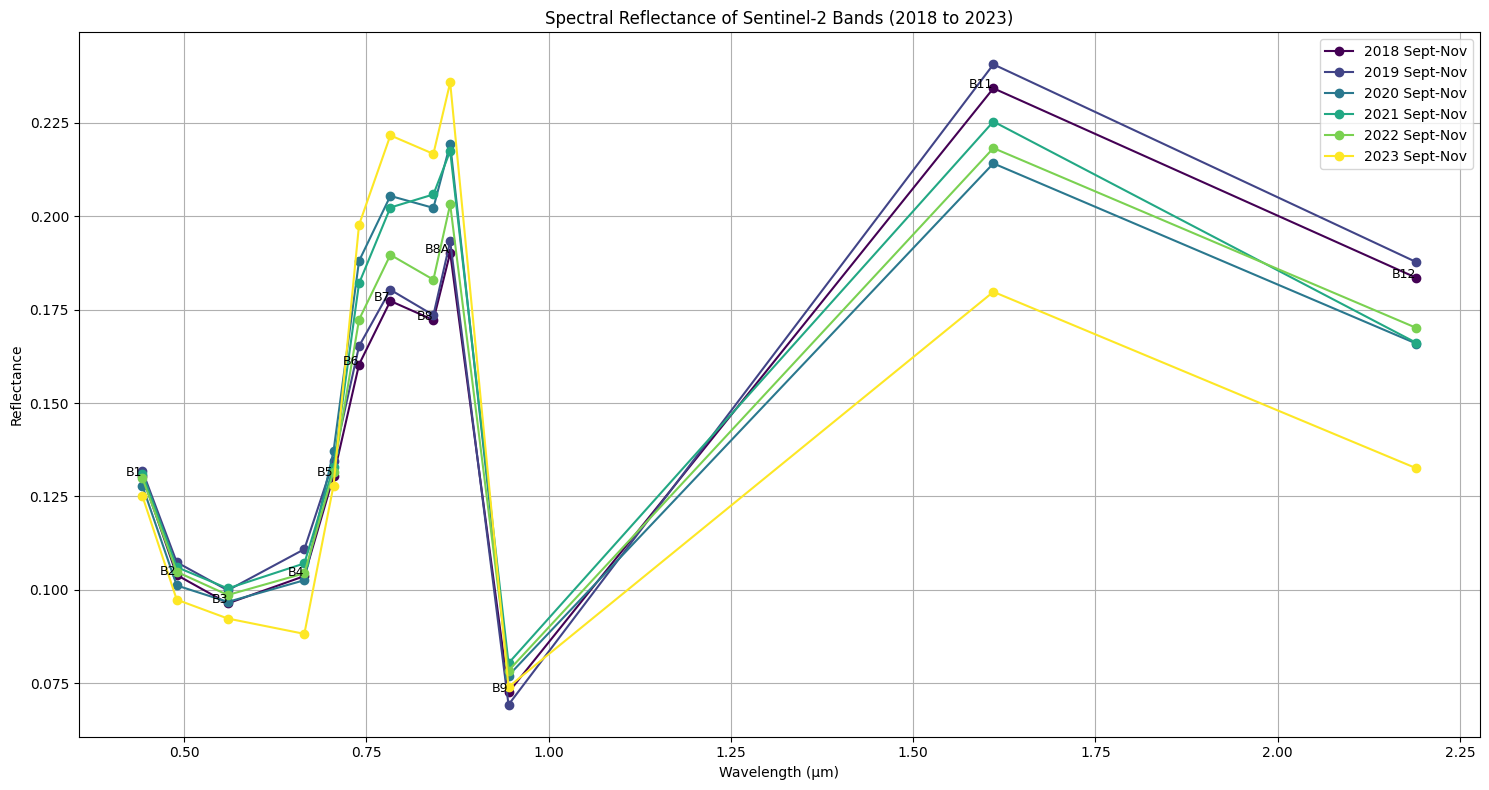

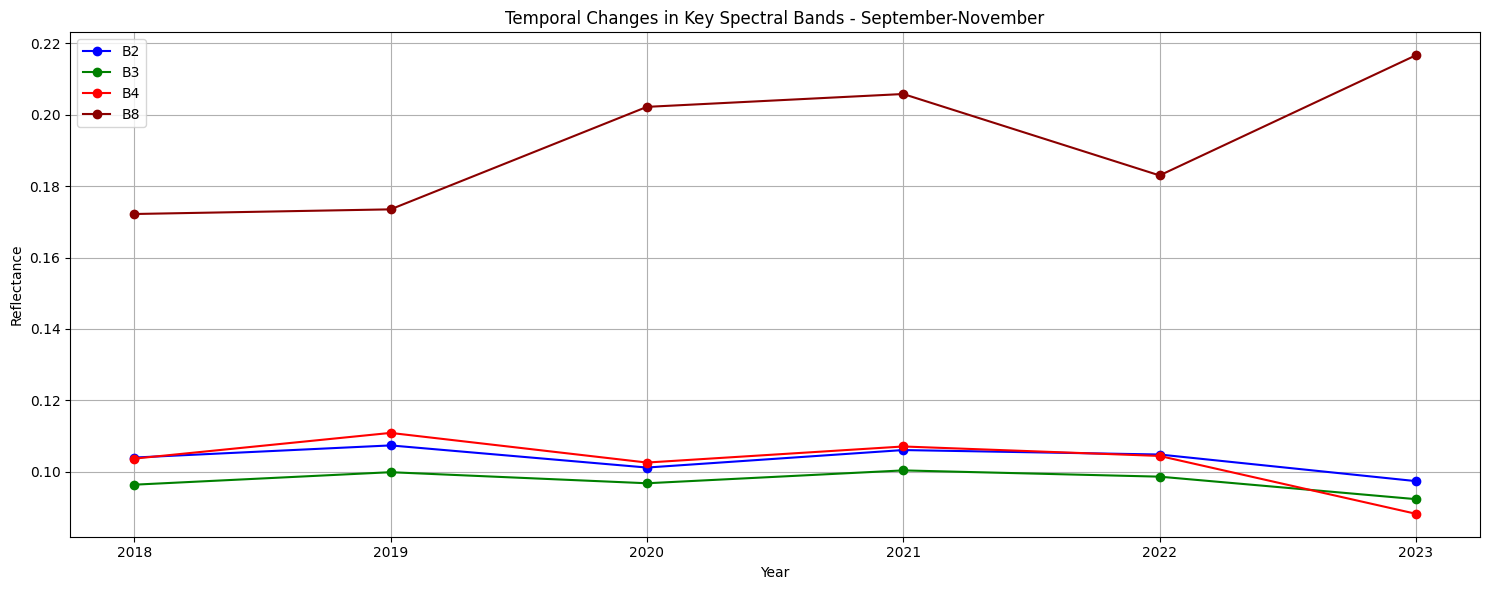

Map(center=[-33.88168117551994, 19.468564513275254], controls=(WidgetControl(options=['position', 'transparent…

In [21]:
# Example usage
point = pts.first().geometry()  # Replace `pts` with your feature collection
start_year = 2018
end_year = 2023

# Example 1: Analyze both periods separately
# plot_spectral_signatures_and_map(point, 2018, 2023, periods=['first', 'second'])

# Example 2: Only analyze the 'both' period (full Sept-Nov)
plot_spectral_signatures_and_map(point, 2018, 2023, periods=['both'])

# Example 3: Default to 'both' if no periods specified
# plot_spectral_signatures_and_map(point, 2018, 2023)

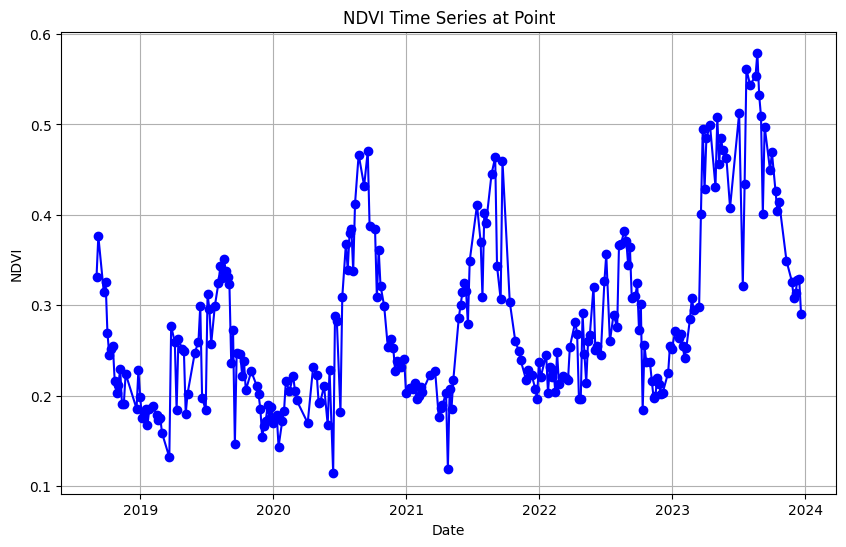

In [72]:
# plot spectral index over time 
import ee
import pandas as pd

# Initialize Earth Engine
ee.Initialize()

# Function to compute a spectral index
def compute_index(image, index_name):
    """
    Compute a spectral index for an image.
    Supported indices: NDVI, EVI, NDWI, etc.
    """
    if index_name == 'NDVI':
        # NDVI = (NIR - Red) / (NIR + Red)
        index = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    elif index_name == 'EVI':
        # EVI = 2.5 * (NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1)
        evi = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }
        ).rename('EVI')
        index = evi
    elif index_name == 'NDWI':
        # NDWI = (Green - NIR) / (Green + NIR)
        index = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    else:
        raise ValueError(f"Unsupported index: {index_name}")
    return image.addBands(index)

# Function to extract a spectral index over time for a point
def extract_index_over_time(point, index_name, start_date, end_date, scale=10):
    """
    Extract a spectral index over time for a specific point.
    
    Args:
        point (ee.Geometry): The point to extract the index for.
        index_name (str): The spectral index to compute (e.g., 'NDVI', 'EVI', 'NDWI').
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        scale (int): Scale in meters for the reduceRegion operation.
    
    Returns:
        pd.DataFrame: A DataFrame with dates and index values.
    """

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65

    # Load the Sentinel-2 image collection
    collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(point) \
        .filterDate(start_date, end_date)\
        .linkCollection(csPlus, [QA_BAND])\
        .map(lambda img: compute_index(img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)), index_name))

    # Extract the index values over time
    def extract_index(image):
        # Reduce the region to the point
        value = image.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=scale
        )
        # # Return the date and index value
        return image.set('date', image.date().format('YYYY-MM-dd')).set(value)

    # Map over the collection to extract values
    time_series = collection.map(extract_index).filter(ee.Filter.notNull([index_name]))

    # Convert the time series to a list of dictionaries
    time_series_list = time_series.aggregate_array(index_name).getInfo()
    date_list = time_series.aggregate_array('date').getInfo()

    # Convert to a pandas DataFrame
    df = pd.DataFrame(date_list, columns=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df[index_name] = time_series_list
    df = df.sort_values('date').reset_index(drop=True)

    return df

# Example usage
point = pts.first().geometry()
index_name = 'NDVI'  # Choose the index (e.g., 'NDVI', 'EVI', 'NDWI')
start_date = '2018-09-01'
end_date = '2023-12-31'

# Extract the index over time
time_series_df = extract_index_over_time(point, index_name, start_date, end_date)

# Plot the time series
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(time_series_df['date'], time_series_df[index_name], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel(index_name)
plt.title(f'{index_name} Time Series at Point')
plt.grid(True)
plt.show()

In [73]:
timelapse = geemap.sentinel2_timelapse(
    point.buffer(5000),
    out_gif='sentinel2.gif',
    start_year= 2018,
    end_year= 2020,
    start_date='09-01',
    end_date='12-01',
    frequency='week',
    bands=['SWIR2','NIR', 'Red'],
    frames_per_second=1,
    title='Sentinel-2 Timelapse',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: /home/geethen/invasives/hypinvalimap/code/sentinel2.gif
No module named 'ffmpeg'


Output()

dynamic world probabilities over time  
sentinel-2 spectral signatures for the same periods over multiple years
create gif  
plot hyperspectral signature for two periods  
Classify pt as same/changed/toClass/inconclusive  

In [ ]:
# extract values at points
data = dem.reduceRegions(collection=pts, reducer=ee.Reducer.first(), scale=30)
data.limit(5)

# convert to geopandas dataframe
pts_gdf = ee.data.computeFeatures({
    'expression': data,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
pts_gdf.crs = 'EPSG:4326'

display(type(pts_gdf))
pts_gdf.head()

# embedding fields

In [3]:
def plotTS(dataset, bandName, geometry_point, start_date, end_date, scale=10, buffer_size=100, weeks_before=12, weeks_after=12):
    """
    Plot time series for Earth Engine data at a specific point location.

    Args:
        dataset (ee.ImageCollection): Earth Engine image collection
        bandName (str): Name of the band to plot
        geometry_point (ee.Geometry.Point or list): Point coordinates as [x, y] or ee.Geometry.Point
        start_date (str or datetime): Start date of interest
        end_date (str or datetime): End date of interest
        scale (int, optional): Scale in meters for data extraction. Defaults to 10.
        buffer_size (int, optional): Buffer size in meters around the point. Defaults to 100.
        weeks_before (int, optional): Number of weeks before start_date to include. Defaults to 12.
        weeks_after (int, optional): Number of weeks after start_date to include. Defaults to 12.

    Returns:
        pd.DataFrame: DataFrame with extracted time series data
    """    
    # Convert dates to ee.Date objects
    if isinstance(start_date, str):
        start_ee_date = ee.Date(start_date)
    else:
        start_ee_date = ee.Date(start_date.strftime('%Y-%m-%d'))
        
    if isinstance(end_date, str):
        end_ee_date = ee.Date(end_date)
    else:
        end_ee_date = ee.Date(end_date.strftime('%Y-%m-%d'))
        
    # Convert start_date to Python datetime for plotting
    if isinstance(start_date, str):
        start_py_date = pd.to_datetime(start_date).date()
    else:
        start_py_date = start_date.date() if hasattr(start_date, 'date') else start_date
        
    # Convert end_date to Python datetime for plotting
    if isinstance(end_date, str):
        end_py_date = pd.to_datetime(end_date).date()
    else:
        end_py_date = end_date.date() if hasattr(end_date, 'date') else end_date
    
    # Create point geometry
    if isinstance(geometry_point, list):
        point = ee.Geometry.Point(geometry_point).buffer(buffer_size)
    else:
        point = geometry_point.buffer(buffer_size)
    
    # Filter the dataset
    filtered_dataset = dataset.select(bandName).filterBounds(point).filterDate(
        start_ee_date.advance(-weeks_before, 'week'), 
        start_ee_date.advance(weeks_after, 'week')
    )

    # Function to extract mean value for each image
    def poi_mean(img):
        mean = img.reduceRegion(
            reducer=ee.Reducer.mean(), 
            geometry=point, 
            scale=scale
        ).get(bandName)
        return ee.Feature(None).set('date', img.date().format()).set('value', mean)
    
    # Map over the collection and extract values
    fc = filtered_dataset.map(poi_mean).filter(ee.Filter.notNull(['value']))
    props = fc.first().propertyNames()
    output = fc.map(lambda ft: ft.set('output', props.map(lambda prop: ft.get(prop))))
    result = output.aggregate_array('output').getInfo()
    
    # Convert to DataFrame
    result = pd.DataFrame(result, columns=props.getInfo())
    result['date'] = pd.to_datetime(result['date']).dt.date
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(result['date'], result['value'], marker='o', linestyle='-', color='xkcd:lightish blue', label=bandName)
    plt.axvline(x=start_py_date, color='red', linestyle='-', label=f'Start date: {start_py_date}')
    plt.axvline(x=end_py_date, color='red', linestyle='--', label=f'End date: {end_py_date}')
    plt.xlabel('Date')
    plt.ylabel(bandName)
    plt.title(f"{bandName} time series")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    
    return result

In [6]:
import itertools

years = list(range(2017, 2024))  # Generates [2018, 2019, 2020, 2021, 2022, 2023]
year_pairs = [list(pair) for pair in itertools.combinations(years, 2)]
year_pairs = [[2018, 2023]]

print(year_pairs)

[[2018, 2023]]


In [8]:
from tqdm.auto import tqdm

efmV2 = ee.ImageCollection('projects/mldp-partners/assets/preview/efm_v2_preview')

# for a point, compute change vectors between all possible year combinations
def embeddingByYear(year):
    return efmV2\
        .filterDate(ee.Date.fromYMD(year,1,1), ee.Date.fromYMD(year,1,1).advance(1, 'year'))\
        .mosaic().pow(2).reduce(ee.Reducer.sum()).sqrt()

def dotProduct(year1, year2):
    #Calculate the dot product.
    dot = embeddingByYear(year1)\
    .multiply(embeddingByYear(year2))\
    .reduce(ee.Reducer.sum())\
    .multiply(-1)\
    .add(1)
    period = ee.String(year2).cat('_').cat(ee.String(year1))
    return dot.selfMask().rename(period)

# extract data
def extractData(point, scale):
    
    changeBands = ee.ImageCollection(ee.List(year_pairs).map(lambda yearList: dotProduct(ee.List(yearList).getNumber(1),
                                                                ee.List(yearList).getNumber(0)))).toBands()\
                                                                    .regexpRename('^[^_]*_', '') #remove all up to and including first underscore
    mean = changeBands.reduceRegion(
            reducer=ee.Reducer.mean(), 
            geometry=point, 
            scale=scale
        )
    
    return ee.Feature(point).set(mean)
    
# eeprint(extractData(point, 30))       

In [10]:
# extract values at points
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/aliens_sep2018')#.filter(ee.Filter.eq('fid',238))

output = pts.map(lambda ft: extractData(ft.geometry(), 30))
# output = extractData(pts.geometry(), 30)

# convert to geopandas dataframe
pts_gdf = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(output),
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
pts_gdf.crs = 'EPSG:4326'

display(type(pts_gdf))
pts_gdf.head()

geopandas.geodataframe.GeoDataFrame

,geometry,2018_2023
0,POINT (19.46856 -33.88168),0.013475
1,POINT (19.4689 -33.88104),0.006865
2,POINT (19.47297 -33.88195),0.010611
3,POINT (19.47367 -33.87662),0.026942
4,POINT (19.46506 -33.88506),0.002919


In [11]:
import os
os.getcwd()

'/home/geethen/invasives/hypinvalimap/code'

In [12]:
pts_gdf.to_file('/home/geethen/invasives/hypinvalimap/data/2018_2023_MgnChg.shp')

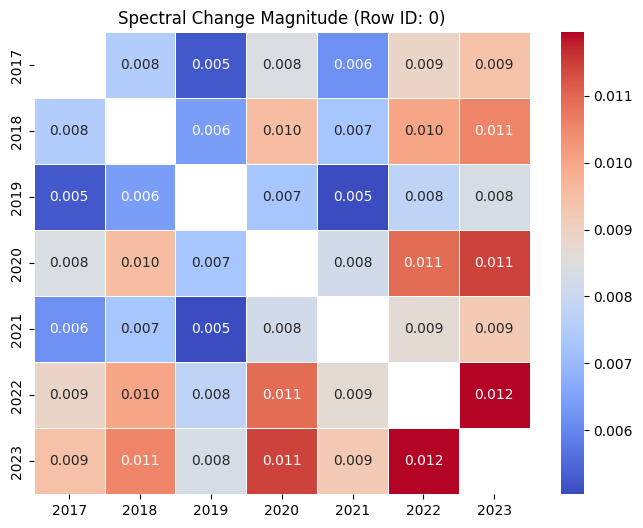

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select a specific row by ID (Index)
row_id = 0  # Change this to select different rows
df = pts_gdf
selected_row = df.iloc[row_id, 1:]  # Exclude 'geometry'

# Extract years from column names
years = sorted(set(int(y) for col in selected_row.index for y in col.split('_')))

# Create an empty DataFrame for the heatmap
change_matrix = pd.DataFrame(np.nan, index=years, columns=years)

# Populate the heatmap with values from the selected row
for col, value in selected_row.items():
    y1, y2 = map(int, col.split('_'))
    change_matrix.loc[y1, y2] = value
    change_matrix.loc[y2, y1] = value  # Make it symmetric

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(change_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title(f"Spectral Change Magnitude (Row ID: {row_id})")
plt.show()


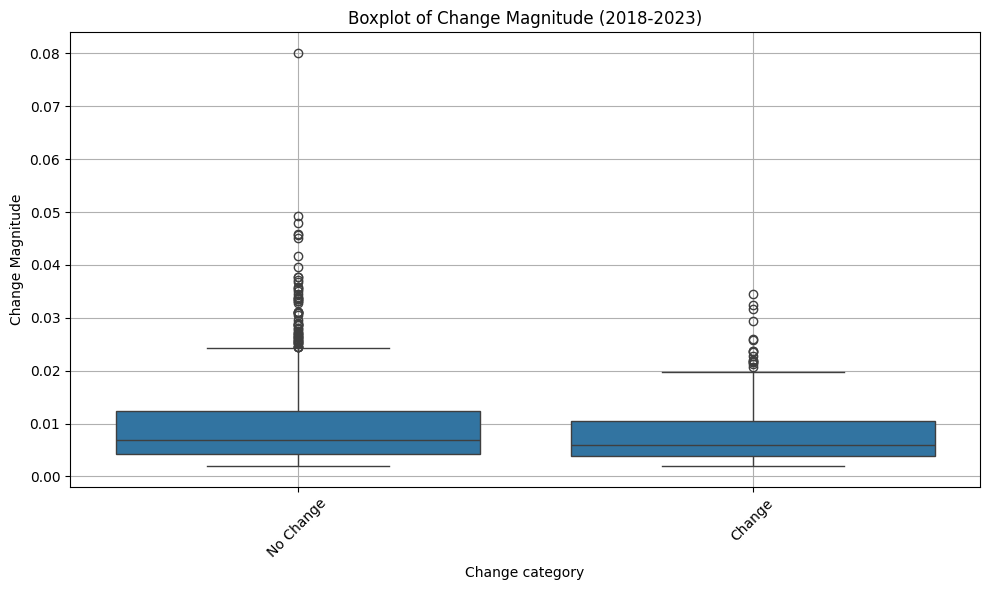

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Load shapefile and clean null geometries
points = gpd.read_file('/home/geethen/invasives/hypinvalimap/data/2018_2023_MgnChg.shp')
points = points[points['geometry'].notnull()]

# Optional: drop rows with NaN in relevant columns
points = points.dropna(subset=['2018_2023', 'change'])  # assuming 'change_category' exists

def plot_boxplot(df, category_col, value_col, title, xticklabels=None):
    """
    Plot a boxplot of value_col grouped by category_col.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        category_col (str): Name of the categorical column for x-axis.
        value_col (str): Name of the numerical column for y-axis.
        title (str): Plot title.
        xticklabels (list, optional): Custom labels for x-axis categories.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=category_col, y=value_col, data=df)
    plt.title(title)
    plt.xlabel('Change category')
    plt.ylabel('Change Magnitude')

    if xticklabels:
        plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot assuming a categorical column like 'change_category'
plot_boxplot(points, 'change', '2018_2023', 'Boxplot of Change Magnitude (2018-2023)', ['No Change', 'Change'])
